<a href="https://colab.research.google.com/github/SAMAWELJABALLI/TweetsSentimentAnalysis/blob/main/template_validation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils import resample
    
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.models import load_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# Load data and set labels from corpus 1 
data = pd.read_csv('/content/data_processed.csv')
print(f'Shape of data is {data.shape}')
# Display 20 random samples
data.sample(20)
data["text_clean"].fillna("No content", inplace = True)

# Separate majority and minority classes in training data for upsampling 
data_majority = data[data['label'] == 0]
data_minority = data[data['label'] == 1]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
print("After upsampling\n",data_upsampled.label.value_counts(),sep = "")

from sklearn.utils import shuffle
data_upsampled = shuffle(data_upsampled)

from keras.preprocessing.text import Tokenizer
data_upsampled = data_upsampled.sample(1000,random_state=100)
print (data_upsampled.shape)
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data_upsampled['text_clean'].values.astype(str))
X = tokenizer.texts_to_sequences(data_upsampled['text_clean'].values.astype(str))
X = pad_sequences(X)

print(X[1])
print(X.shape)
labels = np.array(data_upsampled['label'])
y = []
for i in range(len(labels)):
    if labels[i] == 0:
        y.append(0)
    if labels[i] == 1:
        y.append(1)

y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 2, dtype="int")
labels.shape
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size = 0.30, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of data is (163412, 3)
majority class before upsample: (46831, 3)
minority class before upsample: (116580, 3)
After upsampling
1.0    46831
0.0    46831
Name: label, dtype: int64


In [6]:
# model
embed_dim = 128
lstm_out = 192
EPOCHS = 2
checkpoint_filepath = 'model9.hdf5'
BATCH_SIZE =64

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = 130))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss = 'BinaryCrossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='max', period=1,save_weights_only=True)
history = model.fit(X_train, Y_train, epochs=EPOCHS, validation_data=(X_test, Y_test),callbacks=[checkpoint],batch_size = BATCH_SIZE)
np.save('my_history1.npy',history.history)
model.save(checkpoint_filepath)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 130, 128)          256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 192)               246528    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 386       
Total params: 502,914
Trainable params: 502,914
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
11/11 [==============================] - 12s 760ms/step - loss: 0.6914 - accuracy: 0.5250 - val_loss: 0.6842 - val_accuracy: 0.5367

Epoch 00001: val_accuracy improved from -inf to 0.53667, saving model to model9.hdf5
Epoch 2/2
11/

In [5]:
'''#weights 
model.load_weights(checkpoint_filepath)
model.get_weights()
model.save_weights(checkpoint_filepath, overwrite=True, save_format=None, options=None)
'''

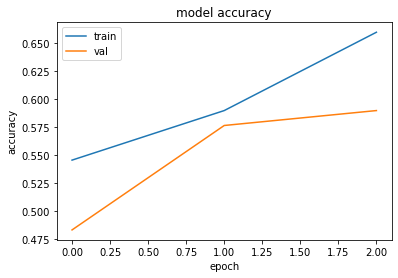

In [42]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

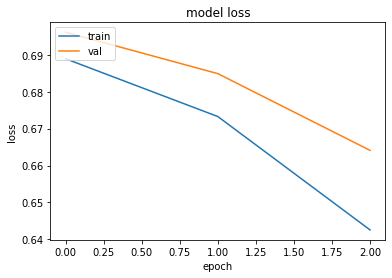

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

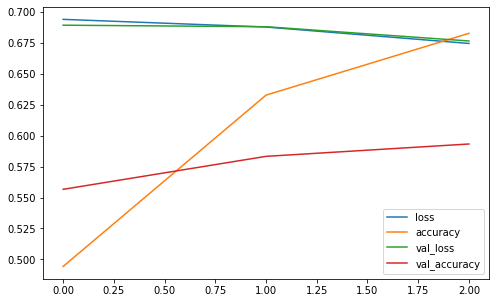

In [21]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()


This builds a graph with the available metrics of the history for all datasets of the history



In [22]:
# Evaluate the model2
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

10/10 [==============================] - 0s 44ms/step - loss: 0.6767 - accuracy: 0.5933
Untrained model, accuracy: 59.33%


In [24]:
#test validation
from sklearn.metrics import confusion_matrix,classification_report


Y_pred = model.predict_classes(X_test,batch_size = 128)
df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred':Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
print("confusion matrix",confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


confusion matrix [[ 61  89]
 [ 33 117]]
              precision    recall  f1-score   support

           0       0.65      0.41      0.50       150
           1       0.57      0.78      0.66       150

    accuracy                           0.59       300
   macro avg       0.61      0.59      0.58       300
weighted avg       0.61      0.59      0.58       300



In [25]:
# model1
text = ['ربي يشفيلك بوك،وان شاء الله غصرة وتتعدى']
def pred(text):
  #vectorizing the tweet by the pre-fitted tokenizer instance
  twt = tokenizer.texts_to_sequences(text)
  #padding the tweet to have exactly the same shape as `embedding_2` input
  twt = pad_sequences(twt, maxlen=X.shape[1], dtype='int32', value=0)
  print(text)
  print(twt)
  sentiment = model.predict(twt)[0]
  if(np.argmax(sentiment) == 0):
      print("***negative***")
  elif (np.argmax(sentiment) == 1):
      print("***positive***")

In [26]:
pred(text)

['ربي يشفيلك بوك،وان شاء الله غصرة وتتعدى']
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0  10 190  16]]
***positive***


In [31]:
model2 = load_model('/content/best_model2.hdf5')
model1 = load_model('/content/best_model1.hdf5')


In [33]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 541, 128)          384000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 541, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 639,194
Trainable params: 639,194
Non-trainable params: 0
_________________________________________________________________
